In [1]:
import warnings
import datetime
import itertools
import numpy as np
import scipy as sp
import cvxpy as cp
import pandas as pd
import yfinance as yf
import seaborn as sns
import ipywidgets as widgets
import matplotlib.pyplot as plt
from functools import reduce
from kit import get_yf_ts, get_dividends, get_div_return

warnings.filterwarnings('ignore')

<b>Stock</b> (or share) is a unit of a company by which ownership of that company is divided. The holder of the stock is entitled to proceeds from the company profits, dividends paid, voting rights as well as proceeds from liquidation of assets. Stocks can be common or preferred, the main difference with preferred stock giving priority to the stockholder of profit proceeds, dividends and first order repayment of liquidation proceeds. Similarly, some stocks have no voting rights, some have enhanced voting rights. 

Stocks of private companies are normally offered to their employees and investors. Purchase and sale of private stock must be approved by the issuing company. In this notebook we focus on properties of stocks of public companies which are traded on stock exchanges. Stock exchanges particularly in developed economies trade stocks in high volumes and are highly regulated by governments and financial bodies to prevent fraud and ensure fair practices.

I'll select one American stock for an example, from Yahoo Finance - AAPL.

<b>Stock price</b>: normally split between a bid (the highest amount someone is willing to buy at) and ask (the lowest amount someone is willing to sell at), shows the current price of one unit of stock on an exchange. The closing price is the price of a unit stock of the last transaction on an exchange before the market closes for trading.

Below we observe Apple's closing stock price in the last 5 years. It's current price (spot price) is roughly at $220.

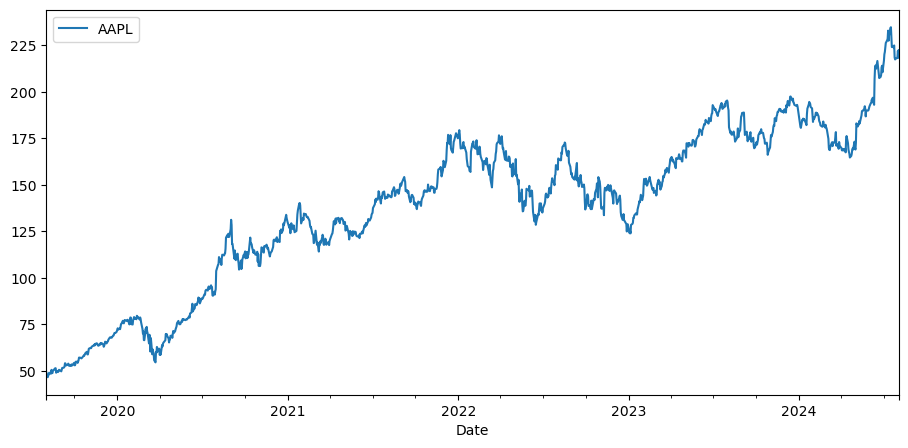

In [3]:
aapl = get_yf_ts('AAPL', '5y', '1d')
aapl.plot(figsize=(11,5))
plt.show()

<b>Capital Gains:</b> Shareholders can earn capital gains if the value of the shares increases and they sell the shares at a higher price than the purchase price.

<b>Returns:</b> are gains or losses on the asset price based on its relative change between measuring periods. $r_t=\frac{p_t - p_{t-1}}{p_{t-1}}$, for stock price $p$ at time $t$. Under the assumption that stock prices are log-normally distributed, commonly the log return is tracked $\log(r_t)$. *I'll put a longer explanation on normality of asset prices and log returns in my returns notebook.

Below we observe the time-series and the histogram of log returns of AAPL in the last 5 years:

In [22]:
returns = (np.log(aapl / aapl.shift(1)))

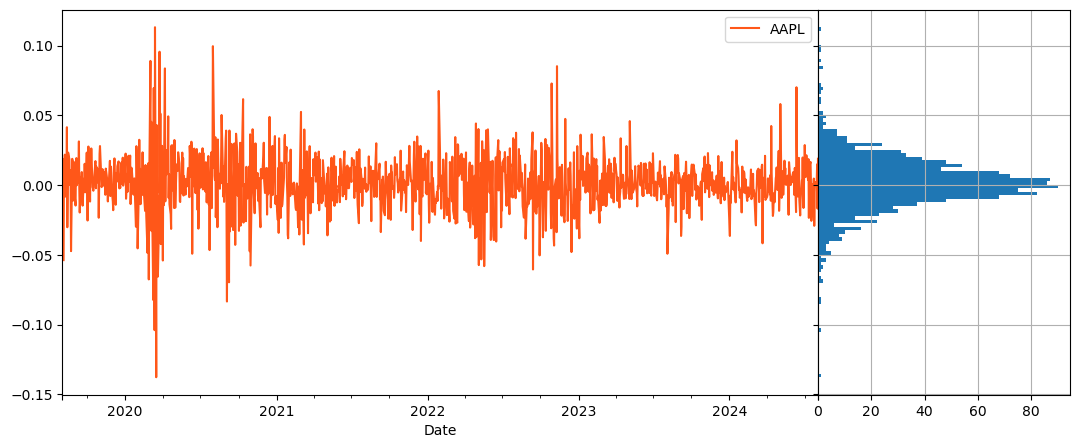

In [114]:
fig, (ret_ts, ret_hist) = plt.subplots(nrows=1, ncols=2, gridspec_kw={'width_ratios':[3, 1]}, figsize=(13, 5))
plt.subplots_adjust(wspace=0)
returns.plot(ax=ret_ts, color='orangered', alpha=0.9)
returns['AAPL'].hist(ax=ret_hist, bins=100, orientation='horizontal')
ret_hist.set_yticklabels([])
fig.show()

Some of the properties below are descriptive of the company, like the industry in which the company operates, the company directors, exchanges on which it trades etc., and some are numeric that show for instance number of employees, outstanding shares or numeric that measure company performance like dividend yield and return per share or numeric that measure market sentiment of that stock like daily trading volumes, short interest etc. I'll cover some of those availalbe in Yahoo Finace.

In [115]:
aapl_info = yf.Ticker('AAPL').info

In [120]:
pd.DataFrame(aapl_info)[['address1', 'city', 'country', 'industry', 'sector', 'fullTimeEmployees', 'longName', 'quoteType', 'currency']].drop_duplicates()

,address1,city,country,industry,sector,fullTimeEmployees,longName,quoteType,currency
0,One Apple Park Way,Cupertino,United States,Consumer Electronics,Technology,161000,Apple Inc.,EQUITY,USD


There's no tick data of bid and ask, however we have the last reported bid and ask price and their corresponding quantities to buy and sell respectively. A few more aggregate metrics on the price, such as the lowest and highest traded for that day, as well as a moving average of the min/max/average daily price for the last year and last 200 days:

In [150]:
pd.DataFrame(aapl_info)[['longName', 'previousClose', 'open', 'dayLow', 'dayHigh', 'bid', 'ask', 'bidSize', 'askSize', 'fiftyTwoWeekLow', 'fiftyTwoWeekHigh', 'fiftyDayAverage', 'twoHundredDayAverage']].drop_duplicates()

,longName,previousClose,open,dayLow,dayHigh,bid,ask,bidSize,askSize,fiftyTwoWeekLow,fiftyTwoWeekHigh,fiftyDayAverage,twoHundredDayAverage
0,Apple Inc.,218.36,219.15,217.71,225.6,219.48,219.9,500,100,164.08,237.23,212.5994,189.52155


Delving into the earnings metrics:
1. <b>Dividend Yield:</b> The amount that a company pays out in dividends each year divided with the stock price
2. <b>Ex-Dividend Date:</b> The date on which the holder of the stock will receive the dividend. In this case is the next announced date for AAPL
3. <b>Last Dividend Value:</b> The last dividend payment in cash, here currency is USD
4. <b> Payout Ratio:</b> Proportion of earnings paid out as dividends to shareholders
5. <b>Total Revenue:</b> The total amount of money brought in AAPL, here measured for one financial year in USD
6. <b>Revenue per Share:</b> $\frac{\text{revenue}}{\text{marketCap}}\text{sharePrice}$
7. <b>Gross Margin:</b> Portion of revenue left after costs are subtracted
8. <b>Profit Margin:</b>$\frac{\text{revenue - cost}}{\text{revenue}}$
9. <b>Book Value:</b> Net value of AAPL's assets on its balance sheet, this is in USD per share. If all of AAPL's assets were liquidated today, that is how much each shareholder would get.
10. <b>Price to Book Ratio (P/B):</b> Price dividend to book value. Some investors use this to identify over/undervalued companies.
11. <b>Forward Earnings per Share:</b> The predicted future earnings per share
12. <b>Trailing Earnings per Share:</b> The current price divided by earnings per share
13. <b>Forward Earnings per Share:</b> Same as (12) except using the forward (expected) earnings per share

These are some of the main metrics (and their time-series) that investors track when deciding whether a company is profitable enough to invest in.

In [177]:
earnings_cols = ["dividendYield", "exDividendDate", 'lastDividendValue', "payoutRatio", "totalRevenue", 'revenuePerShare', "grossMargins", 'profitMargins', 'bookValue', 'priceToBook', 'forwardEps', 'trailingPE', 'forwardPE']
earnings_info = pd.DataFrame(aapl_info)[earnings_cols].drop_duplicates()
earnings_info['exDividendDate'] = earnings_info['exDividendDate'].apply(lambda c: datetime.datetime.fromtimestamp(c).date())
earnings_info

,dividendYield,exDividendDate,lastDividendValue,payoutRatio,totalRevenue,revenuePerShare,grossMargins,profitMargins,bookValue,priceToBook,forwardEps,trailingPE,forwardPE
0,0.0045,2024-08-12,0.25,0.1476,385603010560,24.957,0.45962003,0.26441,4.382,50.17344,7.33,33.46423,29.994543


Looking into more of the balance-sheet metrics:
1. <b>Market Capitalization:</b> The total company value in this case in USD
2. <b>Floating shares:</b> Number of shares that are available on the stock exchanges for trading
3. <b>Shares Outstanding:</b> The total number of shares held by the shareholders
4. <b>Shares Short:</b> The amount of shares that have been borrowed and sold short; a.<b>Short Interest:</b> The ratio of availble shorted shares. $\frac{\text{sharesShort}}{\text{floatShares}}$
5. <b>Short Ratio:</b> More commonly called <b>Days to Cover</b>, is the number of days it takes short sellers on average to cover their positions, that is repurchase all of the borrowed shares. For AAPL below we are observing low amount of shares short and quick turnaround on short sales, meaning investors are exploiting small decreases in the asset price.
6. <b> Total Debt:</b> Money owed to do business, like to creditors or shareholders.
7. <b> Earnings before interest, taxes, depreciation, and amortisation (EBITDA):</b> Measure of a company's profitability of the operating business only, thus before any effects of indebtedness, state-mandated payments, and costs required to maintain its asset base
8. <b> Quick Ratio:</b> Calculated by dividing a company’s most liquid assets like cash, government debt, marketable securities, and pending receivables by total current liabilities; Shows ability of a company to use its cash like liquid assets to close its current liabilities immediately.
9. <b> Current Ratio:</b> $\frac{\text{assets}}{\text{liabilities}}$
10. <b> Debt to Equity:</b> Shows the company's financial leverage and is calculated by dividing a company's total liabilities by its shareholder equity

In [182]:
volume_cols = ['marketCap', 'floatShares', 'sharesOutstanding', 'sharesShort', 'shortRatio', 'totalDebt', 'ebitda', 'quickRatio', 'currentRatio', 'debtToEquity']
volume_info = pd.DataFrame(aapl_info)[volume_cols].drop_duplicates()
volume_info

,marketCap,floatShares,sharesOutstanding,sharesShort,shortRatio,totalDebt,ebitda,quickRatio,currentRatio,debtToEquity
0,3342773518336,15197751163,15204100096,135383184,1.83,101304000512,131781001216,0.798,0.953,151.862


There are significantly more balance sheet metrics tracked particularly for a company as large as Apple, Yahoo Finance provides an API to explore them:

In [187]:
yf.Ticker('AAPL').balancesheet.sort_values('2023-09-30')

,2023-09-30,2022-09-30,2021-09-30,2020-09-30,2019-09-30
Accumulated Depreciation,"-70,884,000,000.0","-72,340,000,000.0","-70,283,000,000.0","-66,760,000,000.0",NaN
Other Equity Adjustments,"-11,452,000,000.0","-11,109,000,000.0","163,000,000.0","-406,000,000.0",NaN
Gains Losses Not Affecting Retained Earnings,"-11,452,000,000.0","-11,109,000,000.0","163,000,000.0","-406,000,000.0",NaN
Working Capital,"-1,742,000,000.0","-18,577,000,000.0","9,355,000,000.0","38,321,000,000.0",NaN
Retained Earnings,"-214,000,000.0","-3,068,000,000.0","5,562,000,000.0","14,966,000,000.0",NaN
...,...,...,...,...,...
Invested Capital,"173,234,000,000.0","170,741,000,000.0","187,809,000,000.0","177,775,000,000.0",NaN
Total Non Current Assets,"209,017,000,000.0","217,350,000,000.0","216,166,000,000.0","180,175,000,000.0",NaN
Total Liabilities Net Minority Interest,"290,437,000,000.0","302,083,000,000.0","287,912,000,000.0","258,549,000,000.0",NaN
Total Assets,"352,583,000,000.0","352,755,000,000.0","351,002,000,000.0","323,888,000,000.0",NaN


<b>Cash flow</b> as the name suggests is the amount of cash that comes in and out of the company in a particular period of time. From the table below, we can see that AAPL measures that annually and reports it at the end of the third quarter of the year. Typically:
1. Cash inflow comes from proceeds from sales and services, investments etc.
2. Cash outflows represents operating outflows like money paid to suppliers, salaries, rent, tax etc., as well as money paid to investors in dividends, interest paid on borrowed money, etc.

In [188]:
yf.Ticker('AAPL').cashflow

,2023-09-30,2022-09-30,2021-09-30,2020-09-30,2019-09-30
Free Cash Flow,"99,584,000,000.0","111,443,000,000.0","92,953,000,000.0","73,365,000,000.0",NaN
Repurchase Of Capital Stock,"-77,550,000,000.0","-89,402,000,000.0","-85,971,000,000.0","-72,358,000,000.0",NaN
Repayment Of Debt,"-11,151,000,000.0","-9,543,000,000.0","-8,750,000,000.0","-12,629,000,000.0",NaN
Issuance Of Debt,"5,228,000,000.0","5,465,000,000.0","20,393,000,000.0","16,091,000,000.0",NaN
Issuance Of Capital Stock,NaN,NaN,"1,105,000,000.0","880,000,000.0","781,000,000.0"
Capital Expenditure,"-10,959,000,000.0","-10,708,000,000.0","-11,085,000,000.0","-7,309,000,000.0",NaN
Interest Paid Supplemental Data,"3,803,000,000.0","2,865,000,000.0","2,687,000,000.0","3,002,000,000.0",NaN
Income Tax Paid Supplemental Data,"18,679,000,000.0","19,573,000,000.0","25,385,000,000.0","9,501,000,000.0",NaN
End Cash Position,"30,737,000,000.0","24,977,000,000.0","35,929,000,000.0","39,789,000,000.0",NaN
Beginning Cash Position,"24,977,000,000.0","35,929,000,000.0","39,789,000,000.0","50,224,000,000.0",NaN


<b>Insider transactions</b> are transactions made by people who currently work for the company, particularly relevant for people at director or senior management positions in the company. To distinguish it properly from <b>insider trading</b>, in this instance the insider reports this transaction properly and there's nothing illegal about it.

Below we observe transactions by some of the most senior people in Apple, for instance the CEO has traded nearly $450mn of shares:

In [202]:
yf.Ticker('AAPL').get_insider_transactions().groupby(['Position', 'Insider'])['Value'].sum()

Position                 Insider           
Chief Executive Officer  COOK TIMOTHY D       438,586,730.0
Chief Financial Officer  MAESTRI LUCA         134,284,575.0
Chief Operating Officer  WILLIAMS JEFFREY E   124,137,815.0
Director                 BELL JAMES A                   0.0
                         GORE ALBERT A JR               0.0
                         GORSKY ALEX                    0.0
                         JUNG ANDREA                    0.0
                         LEVINSON ARTHUR D     33,269,864.0
                         LOZANO MONICA C.               0.0
                         SUGAR RONALD D                 0.0
                         WAGNER SUSAN L                 0.0
General Counsel          ADAMS KATHERINE L    106,519,368.0
Officer                  KONDO CHRISTOPHER      9,759,337.0
                         O'BRIEN DEIRDRE       89,183,937.0
Name: Value, dtype: float64

Below we observe the largest <b>institutional holders</b> of Apple, with its current market value and percentage of the total market capitalization:

In [206]:
yf.Ticker('AAPL').institutional_holders

,Date Reported,Holder,pctHeld,Shares,Value
0,2023-06-30,Vanguard Group Inc,0.0834,1303688506,252876459508
1,2023-06-30,Blackrock Inc.,0.0665,1039640859,201659137420
2,2023-06-30,"Berkshire Hathaway, Inc",0.0586,915560382,177591247296
3,2023-06-30,State Street Corporation,0.037,578897858,112288817516
4,2023-06-30,"FMR, LLC",0.0196,307066638,59561715772
5,2023-06-30,"Geode Capital Management, LLC",0.0186,291538165,56549657865
6,2023-06-30,Price (T.Rowe) Associates Inc,0.0145000005,226650943,43963483413
7,2023-06-30,Morgan Stanley,0.013099999,204714950,39708558851
8,2022-12-31,Norges Bank Investment Management,0.0107,167374278,21746939940
9,2023-06-30,Northern Trust Corporation,0.0105,164536073,31915062079


Similarly, the <b>stock can be held in a fund that tracks a given index</b> in America typically the S&P 500, below we observe the funds that hold the largest amount of Apple for that purpose:

In [209]:
yf.Ticker('AAPL').mutualfund_holders

,Date Reported,Holder,pctHeld,Shares,Value
0,2023-06-30,Vanguard Total Stock Market Index Fund,0.0298,465990265,90388131702
1,2023-06-30,Vanguard 500 Index Fund,0.0225,352024182,68282130582
2,2023-08-31,Fidelity 500 Index Fund,0.0108,169378703,31821176932
3,2023-09-30,SPDR S&P 500 ETF Trust,0.0106,165192563,28282618711
4,2023-09-30,iShares Core S&P 500 ETF,0.0089,138984763,23795581273
5,2023-06-30,Vanguard Growth Index Fund,0.0081,127130805,24659562245
6,2023-08-31,"Invesco ETF Tr-Invesco QQQ Tr, Series 1 ETF",0.008,124293053,23350935867
7,2023-06-30,Vanguard Institutional Index Fund-Institutiona...,0.0064999997,100926716,19576755102
8,2023-08-31,Vanguard Information Technology Index Fund,0.0049,76972129,14460753875
9,2023-09-30,Select Sector SPDR Fund-Technology,0.0041,64568089,11054702517


All this data and often much more is used by investors to compare companies and make decisions on which stocks to buy or sell. This data is also used in sophisticated statistical models and/or Machine Learning techniques that identify company value and growth and trade or advise investors how to trade.

Apart from directly being used in making an investment decision, <b>analysts in financial companies use it to give a rating of the prospected growth of a company</b>. The analysts normally give 3 ratings buy/hold/sell. Below we observe the most recent such analyst suggestions for the month of July:

In [214]:
yf.Ticker('AAPL').upgrades_downgrades.sort_index(ascending=False).head(15).drop_duplicates()

,Firm,ToGrade,FromGrade,Action
GradeDate,,,,
2024-07-29 17:04:14,TD Cowen,Buy,Buy,main
2024-07-26 17:27:02,Raymond James,Outperform,Outperform,main
2024-07-25 09:11:34,Baird,Outperform,Outperform,main
2024-07-24 16:06:57,Barclays,Underweight,Underweight,main
2024-07-24 12:25:40,JP Morgan,Overweight,Overweight,main
2024-07-18 14:37:54,Goldman Sachs,Buy,Buy,main
2024-07-17 18:19:22,CFRA,Buy,Buy,main
2024-07-15 12:08:21,Loop Capital,Buy,Hold,up
2024-07-15 09:41:27,Morgan Stanley,Overweight,Overweight,main
